In [4]:
using Pkg, Revise
Pkg.activate("../NOTEBOOKS/GenLinAlgProblems")
# cd into GenLinAlgProblems, start julia, and add the package to dev:   pkg> dev .
using GenLinAlgProblems, LinearAlgebra, RowEchelon, Latexify, SymPy, Random

using PyCall
itikz = pyimport("itikz")
nM    = pyimport("itikz.nicematrix")
jinja=pyimport("jinja2");

# Using the computer to produce a nice layout of the computations
function ge( matrices, desc, pivot_cols; Nrhs=0, formater=to_latex,
             variable_colors=["blue","black"], pivot_colors=["blue","yellow!40"],
             comment_list=[], array_names=nothing,
             start_index=1, func=nothing, fig_scale=nothing, tmp_dir="./tmp", keep_file="./tmp/pb" )

    M = size(matrices[1][end],1)
    N = size(matrices[1][end],2)-Nrhs

    pivot_list, bg_for_entries, ref_path_list, variable_summary = decorate_ge(desc, pivot_cols, (M,N); pivot_color=pivot_colors[2]);

    h,m=nM.ge( formater(matrices), formater=x->x, Nrhs=Nrhs,
               pivot_list       = pivot_list,
               bg_for_entries   = bg_for_entries,
               variable_colors  = variable_colors,pivot_text_color=pivot_colors[1],
               ref_path_list    = ref_path_list, comment_list=comment_list,
               variable_summary = variable_summary,
               array_names      = array_names,
               start_index      = start_index,
               func             = func,
               fig_scale        = fig_scale,
               tmp_dir          = tmp_dir, keep_file=keep_file    )
    h
end;

  Activating project at `C:\Users\Edgar Auger\NOTEBOOKS\GenLinAlgProblems`


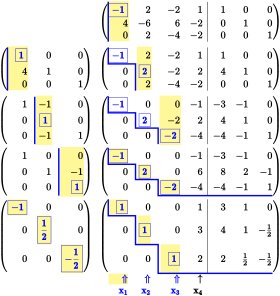

In [5]:
A = [ -1 2 -2 1; 4 -6 6 -2; 0 2 -4 -2 ]
Ab = [ A I ]
matrices, pivot_cols, desc = reduce_to_ref( Ab; n = 4, gj=true )

ge( matrices, desc, pivot_cols; Nrhs=3, tmp_dir="/tmp" )

# Example

In [ ]:
src=raw"\documentclass[tikz]{standalone}

       \begin{document}
       \begin{tikzpicture}[scale=0.5]
       \draw[help lines] grid (5, 5);
       \draw[fill=magenta!10] (1, 1) rectangle (2, 2);
       \draw[fill=magenta!10] (2, 1) rectangle (3, 2);
       \draw[fill=magenta!10] (3, 1) rectangle (4, 2);
       \draw[fill=magenta!10] (3, 2) rectangle (4, 3);
       \draw[fill=magenta!10] (2, 3) rectangle (3, 4);

       \end{tikzpicture}
       \end{document}"

itikz.fetch_or_compile_svg(src,"", "/tmp", false, false )

# Main Functions

The toolchain tex_command -> svg_converter -> crop_program
succeeds or fails depending on tex engine, documentclass and packages.

To set up the toolchain, run

In [ ]:
?itikz.build_commands

Use the output of build_commands to invoke the toolchain on a tex document string

In [ ]:
?itikz.fetch_or_compile_svg

# Commutative Diagram Example

In [ ]:
src = raw"""
\documentclass[tikz]{standalone}
\usepackage{tikz-cd}
\usetikzlibrary{cd}

\begin{document}
\begin{tikzcd}
T
\arrow[drr, bend left, "x"]
\arrow[ddr, bend right, "y"]
\arrow[dr, dotted, "{(x,y)}" description] & & \\
& X \times_Z Y \arrow[r, "p"] \arrow[d, "q"]
& X \arrow[d, "f"] \\
& Y \arrow[r, "g"]
& Z
\end{tikzcd}
\end{document}
"""

cmds = itikz.build_commands_dict(use_xetex=false,use_dvi=false,crop=false)
itikz.fetch_or_compile_svg(src, prefix="cd_", working_dir="/tmp/itikz", full_err=false, debug=false,
                            tex_program=cmds["tex_program"], svg_converter=cmds["svg_converter"],svg_crop=cmds["svg_crop"])

# Linear Algebra Examples

In [ ]:
# REQUIRES FIX: julia needs to pass a list of lists to python
# workaround: pass to ge

mat_rep = raw"""
      &&                   A &                    b \\  \noalign{\vskip1.5mm}
E_1   &&               E_1 A &                E_1 b \\  \noalign{\vskip1.5mm}
E_2   &&           E_2 E_1 A &            E_2 E_1 b \\  \noalign{\vskip1.5mm}
\dots && \dots               & \dots                \\  \noalign{\vskip1.5mm}
E_k   && E_k \dots E_2 E_1 A &  E_k \dots E_2 E_1 b
"""
submatrix_locs=[ ["name=A1", "{1-3}{1-4}"], ["name=A2", "{2-3}{2-4}"], ["name=A3", "{3-3}{3-4}"], ["name=A4", "{5-3}{5-4}"],
                 ["name=A5", "{2-1}{2-1}"], ["name=A6", "{3-1}{3-1}"], ["name=A7", "{5-1}{5-1}"]
               ]
pivot_locs    = []
txt_with_locs = []
mat_format    = "{ccrIr}"

cmds = itikz.build_commands_dict(use_xetex=true,use_dvi=false,crop=true)
itikz.fetch_or_compile_svg( jinja.Template( nM.GE_TEMPLATE ).render( preamble=nM.preamble, extension=nM.extension,
                                                                      mat_rep=mat_rep, mat_format=mat_format, submatrix_locs=submatrix_locs, pivot_locs=pivot_locs, txt_with_locs=txt_with_locs),
                            prefix="test_", working_dir="/tmp/itikz", debug=false,
                            keep_file="/tmp/itikz/foo",
                            tex_program=cmds["tex_program"], svg_converter=cmds["svg_converter"],svg_crop=cmds["svg_crop"], nexec=1 )

In [ ]:
using LinearAlgebra, Latexify
function to_latex_str(x)
    if x < 0  # fix up minus signs
        replace( "-"*latexify(-x), "\$"=>"")
    else
        replace( latexify(x), "\$"=>"")
    end
end

# -----------------------------------------------------------------------------------
# Look at the following matrix
A  = [ 1 3 1 4;  -2 5 5 6;  1 3 1 5;   2 2 8 2     ];               p1 = (0,0)
E1 = [ 1 0 0 0;  2 1 0 0;  -1 0 1 0;  -2 0 0 1     ]; A1 = E1 * A;  p2 = (1,1)
E2 = [ 1 0 0 0;  0 1 0 0;   0 0 1 0;   0 4//11 0 1 ]; A2 = E2 * A1; p3 = (2,3)
E3 = [ 1 0 0 0;  0 1 0 0;   0 0 0 1;   0 0 1 0     ]; A3 = E3 * A2; p4 = (2,2)

# -----------------------------------------------------------------------------------
matrices = [[ :none,               to_latex_str.( A  )],
            [ to_latex_str.( E1 ), to_latex_str.( A1 )],
            [ to_latex_str.( E2 ), to_latex_str.( A2 )],
            [ to_latex_str.( E3 ), to_latex_str.( A3 )] ]

m3 = nM.MatrixGridLayout(matrices, extra_cols=1)

m3.array_format_string_list( partitions = Dict( 1 => [3]) )
m3.array_of_tex_entries(formater=x->x)
red_box = nM.make_decorator( text_color="red", boxed=true, bf=true )
m3.decorate_tex_entries( 0,1, red_box, entries=[p1] )
m3.decorate_tex_entries( 1,1, red_box, entries=[p1,p2] )
m3.decorate_tex_entries( 2,1, red_box, entries=[p1,p2,p3] )
m3.decorate_tex_entries( 3,1, red_box, entries=[p1,p2,p4] )

#m3.nm_text(txt)

m3.nm_submatrix_locs()
m3.tex_repr()

m3_code = m3.nm_latexdoc(template = nM.GE_TEMPLATE )
cmds    = itikz.build_commands_dict(use_xetex=true,use_dvi=false,crop=true)

h = itikz.fetch_or_compile_svg(
        m3_code, prefix="m3_", working_dir="/tmp", debug=false,
        tex_program=cmds["tex_program"], svg_converter=cmds["svg_converter"],svg_crop=cmds["svg_crop"],
        nexec=4, keep_file="m3_" )
h

In [ ]:
print(m3_code)

In [ ]:
A = [ 1  1 -1
      1 -2  1
     -1 -1  2
      1  1 -1]
W = [ 1  1  1
      1 -3  0
     -1 -1  2
      1  1  1]

h,mz = nM.gram_schmidt_qr( A, W )
h